In [1]:
from LSTM import *
from data_getter import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import pickle
import time

In [2]:
directory = 'D:/archive/tensors/'

In [3]:
users_tensor = load_tensor(directory+'users/')

In [4]:
plot_data = {}
epochs = 3
for grade in tqdm(range(1,13)):
    users = users_tensor[users_tensor[:,4]==grade][:,0]
    for number_of_networks in range(1,3):
        if number_of_networks == 1:
            tensor =  get_tensor(directory+'data/')
        else:
            tensor = gender_get_tensor(directory)
        tensor = tensor[torch.isin(tensor[:,2],users)]
        model = LSTM(tensor,3,3)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.7)
        mini_batch_size = min([model.test_users.shape[0]//20,20])
        #training
        for epoch in range(epochs):
            model.split_users()
            mini_batches = model.training_users.shape[0]//mini_batch_size 
            for mini_batch_number in range(mini_batches):
                mini_batch = model.get_mini_batch('train',mini_batch_size)
                for n in range(1,model.days):
                    data = mini_batch[mini_batch[:,1]==n]
                    if data.shape[0]>0:
                        ground = data[:,-1].to(dtype=torch.float)
                        output = model(data)
                        loss = model.loss(ground,output)
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                        model.h.detach_()
                        model.C.detach_()
        #test
        x = []
        y = []
        batch_number = 0
        for mini_batch_number in range(model.test_users.shape[0]//mini_batch_size):
            mini_batch = model.get_mini_batch('test',mini_batch_size)
            batch_number += 1
            losses = []
            prediction_count = 0
            ground_count = 0
            problem_count = 0
            for n in range(1,model.days):
                data = mini_batch[mini_batch[:,1]==n]
                if data.shape[0]>0:
                    output = model(data)
                    ground = data[:,-1].to(dtype=torch.float)
                    loss = model.loss(ground,output)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    losses.append(loss.item())
                    model.h.detach_()
                    model.C.detach_()
            x.append(batch_number)
            y.append(sum(losses)/len(losses))
        plot_data[(grade,number_of_networks)] = (x,y)
    del model
    del tensor
name = 'gender_all_grades_network_'+str(int(time.time()))
file = open('data/' + name + '.pkl', 'wb+')
pickle.dump(plot_data,file)
file.close()

100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [8:37:19<00:00, 2586.63s/it]


In [5]:
print('File Name: ', name)

File Name:  gender_all_grades_network_1698160108


In [8]:
file = open('data/gender_all_grades_network_1698160108.pkl','rb') 
plot_data = pickle.load(file)

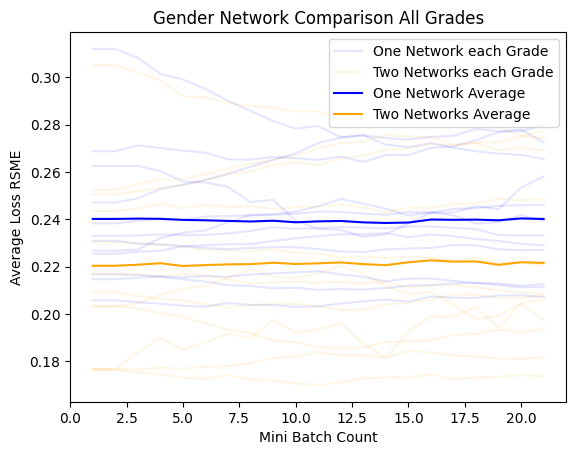

In [14]:
min_points = np.inf
for key in list(plot_data.keys()):
    if len(plot_data[key][0])<20:
        plot_data.pop(key)
    else: 
        min_points = min([min_points,len(plot_data[key][0])])
one_network = np.zeros((12,min_points))
two_networks = np.zeros((12,min_points))
for key in plot_data.keys():
    if key[1] == 1:
        one_network[key[0]-1,:] = np.array(plot_data[key][1][:min_points])
    else:
        two_networks[key[0]-1,:] = np.array(plot_data[key][1][:min_points])
plotted_one = False
plotted_two = False
for key in plot_data.keys():
    x, y = plot_data[key]
    x = x[:min_points]
    y = y[:min_points]
    y_padded = 10*[y[0]]+y
    running_sum = [sum(y_padded[n:n+10])/10 for n in range(len(y))]
    if key[1] == 1:
        if plotted_one: 
            plt.plot(x,running_sum,alpha=0.1,color="blue")
        else: 
            plt.plot(x,running_sum,alpha=0.1,color="blue", label="One Network each Grade")
            plotted_one = True
    else: 
        if plotted_two: 
            plt.plot(x,running_sum,alpha=0.1,color="orange")
        else: 
            plt.plot(x,running_sum,alpha=0.1,color="orange", label="Two Networks each Grade")
            plotted_two = True
y = list(np.mean(one_network,axis=0))
y_padded = 10*[y[0]]+y
running_sum = [sum(y_padded[n:n+10])/10 for n in range(len(y))]
plt.plot(x,running_sum,color="blue",label="One Network Average")
y = list(np.mean(two_networks,axis=0))
y_padded = 10*[y[0]]+y
running_sum = [sum(y_padded[n:n+10])/10 for n in range(len(y))]
plt.plot(x,running_sum,color="orange",label="Two Networks Average")
plt.title("Gender Network Comparison All Grades")
plt.xlabel("Mini Batch Count")
plt.ylabel("Average Loss RSME")
plt.legend()
plt.show()